# Partial Dependence  Documentation

This notebook is designed to demonstrate how to use `mintpy` to compute 1D or 2D partial dependence and plot the results. For more information on dataset and initializing `InterpretToolkit`, see the permutatation importance notebook.

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)

In [2]:
import mintpy
import plotting_config 

## Loading the training data and pre-fit models 

In [3]:
model_objs, model_names = mintpy.load_models()
examples, targets = mintpy.load_data()

### Loading permutation importance results

In [4]:
myInterpreter = mintpy.InterpretToolkit(models=model_objs,
                                 model_names=model_names,
                                 examples=examples,
                                 targets=targets,
                                )

# Load the permutation important results from the saved pickle file
results = myInterpreter.load_results(fnames='multipass_importance_naupdc.nc',)

important_vars = myInterpreter.get_important_vars(results, multipass=True, n_vars=7)

OrderedDict([('Random Forest', RandomForestClassifier(min_samples_leaf=5, n_estimators=200, n_jobs=5)), ('Gradient Boosting', GradientBoostingClassifier()), ('Logistic Regression', LogisticRegression(C=1))]) ['Random Forest', 'Gradient Boosting', 'Logistic Regression']
<xarray.Dataset>
Dimensions:                                   (n_bootstrap: 5, n_vars_multipass: 10, n_vars_singlepass: 30)
Dimensions without coordinates: n_bootstrap, n_vars_multipass, n_vars_singlepass
Data variables:
    multipass_rankings__Random Forest         (n_vars_multipass) object ...
    multipass_scores__Random Forest           (n_vars_multipass, n_bootstrap) float64 ...
    singlepass_rankings__Random Forest        (n_vars_singlepass) object ...
    singlepass_scores__Random Forest          (n_vars_singlepass, n_bootstrap) float64 ...
    original_score__Random Forest             (n_bootstrap) float64 ...
    multipass_rankings__Gradient Boosting     (n_vars_multipass) object ...
    multipass_scores__Grad

# Partial Dependence Plots

Once we known what features are important, we explore their functional relationship with the target variable. MintPy has a built-in function to take the important features from multiple model turn it into a single list with any duplicate features removed. 

In [6]:
important_vars = ['sfcT_hrs_bl_frez', 'temp2m',  'sfc_temp', 'uplwav_flux']
results = myInterpreter.calc_pd( features=important_vars, 
                                 n_bootstrap=1, 
                                 subsample=10000,
                                 n_jobs=len(important_vars)*len(model_names),
                                 n_bins=20
                                )

In [7]:
results

<xarray.Dataset>
Dimensions:                   (n_bins__urban: 20, n_bootstrap: 1, n_examples: 10000)
Dimensions without coordinates: n_bins__urban, n_bootstrap, n_examples
Data variables:
    urban__Random Forest__pd  (n_bootstrap, n_bins__urban) float64 0.00227 .....
    urban                     (n_examples) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    urban__bin_values         (n_bins__urban) float64 0.0 0.05263 ... 0.9474 1.0
Attributes:
    model_output:  probability
    models used:   ['Random Forest', 'Gradient Boosting', 'Logistic Regression']
    method:        pd
    dimension:     1D

KeyError: 'urban__Gradient Boosting__pd'

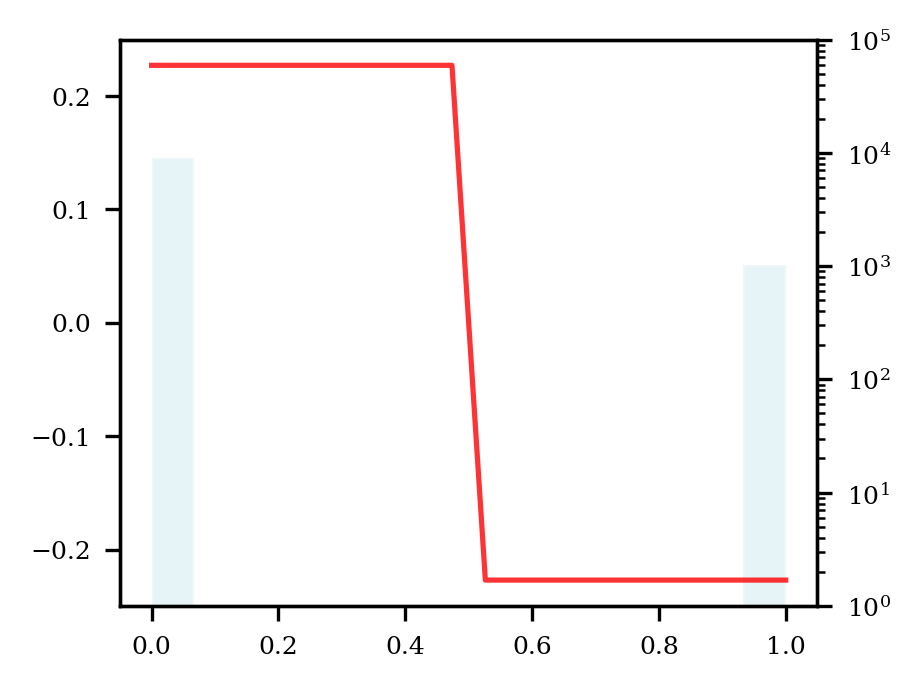

In [8]:
fig, axes = myInterpreter.plot_pd(display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                  )

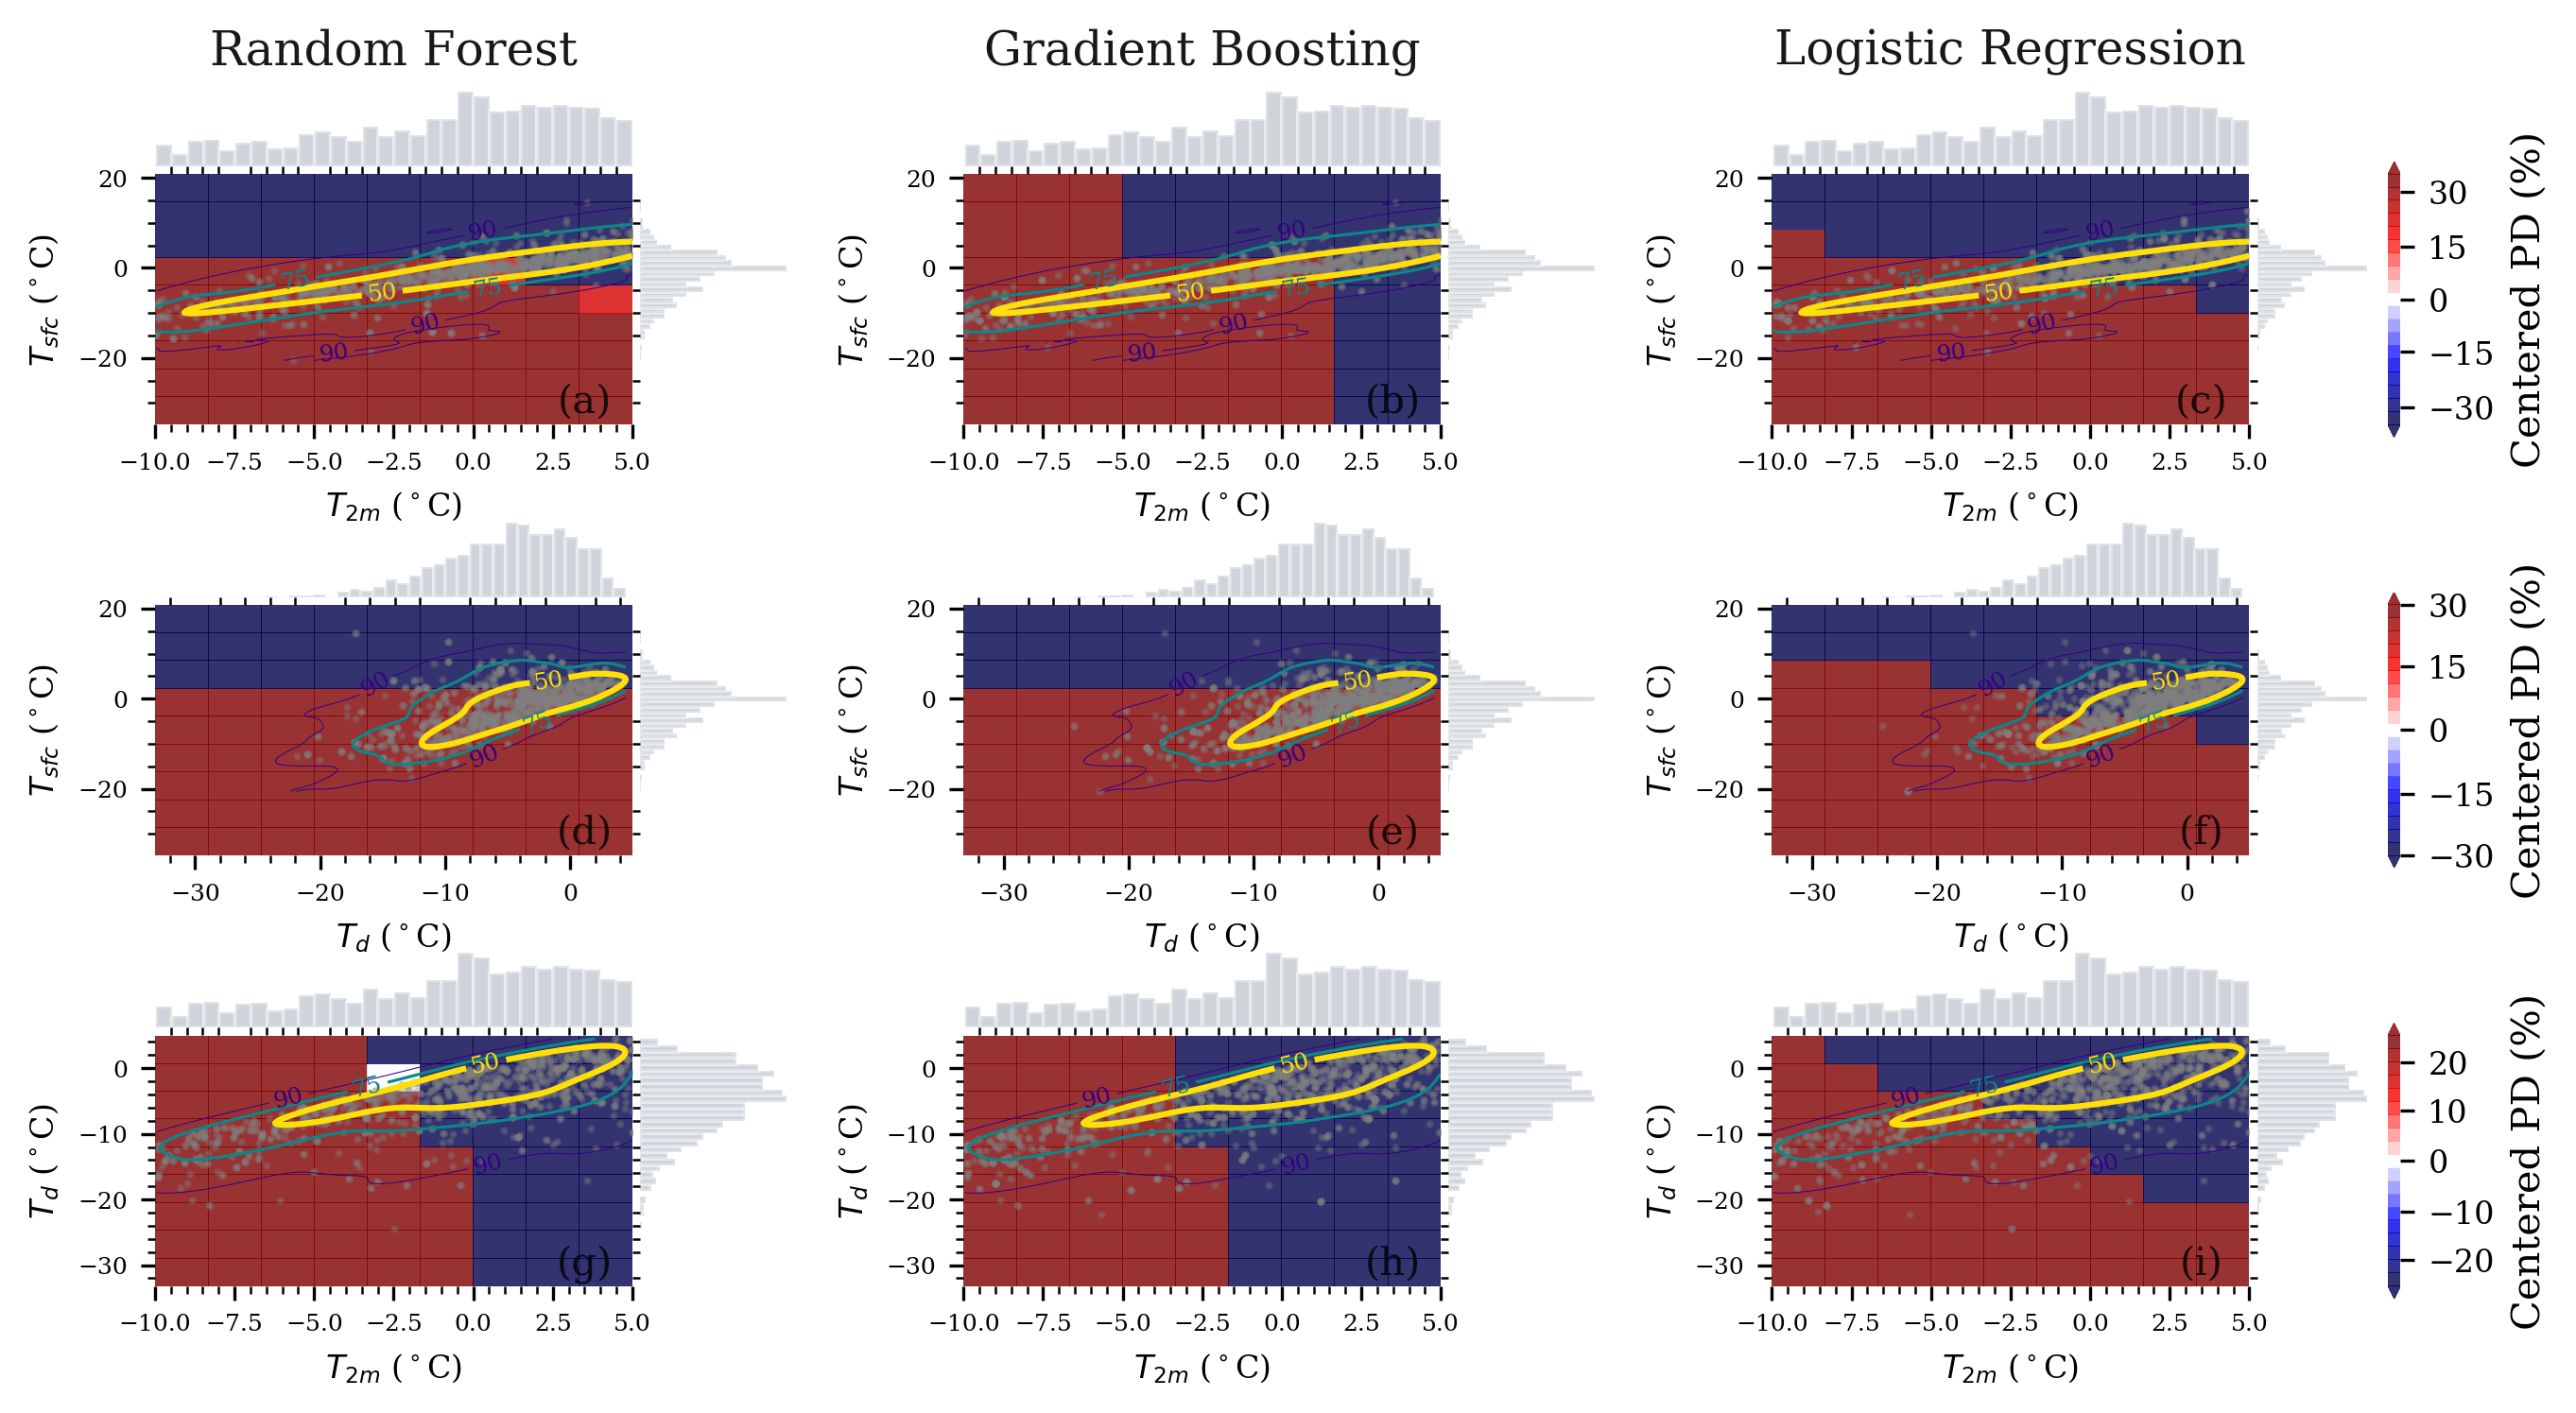

In [8]:
features=[('temp2m', 'sfc_temp'), ('dwpt2m', 'sfc_temp'), ('temp2m', 'dwpt2m')]
results = myInterpreter.calc_pd(features=features, 
                                 n_bootstrap=1, 
                                 subsample=1000,
                                 n_jobs=len(features)*len(model_names),
                                 n_bins=10
                                )

fig, axes = myInterpreter.plot_pd(display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                  )

In [9]:
results

<xarray.Dataset>
Dimensions:                                    (n_bins__dwpt2m: 10, n_bins__sfc_temp: 10, n_bins__temp2m: 10, n_binssfc_temp: 10, n_bootstrap: 1, n_examples: 1000)
Dimensions without coordinates: n_bins__dwpt2m, n_bins__sfc_temp, n_bins__temp2m, n_binssfc_temp, n_bootstrap, n_examples
Data variables:
    dwpt2m                                     (n_examples) float64 -12.34 .....
    temp2m__dwpt2m__Logistic Regression__pd    (n_bootstrap, n_bins__temp2m, n_bins__dwpt2m) float64 ...
    dwpt2m__bin_values                         (n_bins__dwpt2m) float64 -33.2...
    dwpt2m__sfc_temp__Gradient Boosting__pd    (n_bootstrap, n_bins__dwpt2m, n_bins__sfc_temp) float64 ...
    temp2m__dwpt2m__Gradient Boosting__pd      (n_bootstrap, n_bins__temp2m, n_bins__dwpt2m) float64 ...
    temp2m__sfc_temp__Gradient Boosting__pd    (n_bootstrap, n_bins__temp2m, n_bins__sfc_temp) float64 ...
    temp2m__bin_values                         (n_bins__temp2m) float64 -10.0...
    dwpt2m__sfc_temp__Random Forest__pd        (n_bootstrap, n_bins__dwpt2m, n_bins__sfc_temp) float64 ...
    temp2m__dwpt2m__Random Forest__pd          (n_bootstrap, n_bins__temp2m, n_bins__dwpt2m) float64 ...
    temp2m                                     (n_examples) float64 -9.54 ......
    dwpt2m__sfc_temp__Logistic Regression__pd  (n_bootstrap, n_bins__dwpt2m, n_bins__sfc_temp) float64 ...
    temp2m__sfc_temp__Random Forest__pd        (n_bootstrap, n_bins__temp2m, n_bins__sfc_temp) float64 ...
    temp2m__sfc_temp__Logistic Regression__pd  (n_bootstrap, n_bins__temp2m, n_bins__sfc_temp) float64 ...
    sfc_temp__bin_values                       (n_binssfc_temp) float64 -34.7...
    sfc_temp                                   (n_examples) float64 -11.07 .....
Attributes:
    model_output:  probability
    models used:   ['Random Forest', 'Gradient Boosting', 'Logistic Regression']
    method:        pd
    dimension:     2D

### Friedman's Second-order H-statistic

Using PD, we compute the Friedman H-statistic that quantifies the degree to which two features interact with each other. If the two features do not interact, then their second-order PD will equal the sum of their first order effects. 


In [5]:
hstat = myInterpreter.calc_friedman_h_stat(model_name = 'Random Forest',
                                           features = ('temp2m', 'sfc_temp'),
                                           subsample=20000,
                                           n_bins=30
                                          )
print(hstat)

0.04636765886099298


The small value of the second-order H-statistics suggests that 2-m temperature and surface temperature do not strongly interact with the Random Forest for predicting sub-freezing road temperatures. This is not surprisingly given that these features are highly correlated.